<a href="https://colab.research.google.com/github/tiffany-mo/formal-slang-translator/blob/main/NormalToSlang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
!nvidia-smi

Tue Dec  9 22:13:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd

df = pd.read_csv("hf://datasets/Programmer-RD-AI/genz-slang-pairs-1k/genz_dataset.csv")

In [4]:
print(df.shape)
df.head()

(1005, 2)


,normal,gen_z
0,"I'm really tired today, I think I need some rest.","I'm totally drained today, need to catch some ..."
1,"I'm really tired today, I just want to relax a...","I'm hella drained today, just wanna chill at h..."
2,I'm really excited for the concert tonight.,I'm so hype for the concert tonight.
3,"I'm really tired today, I think I need some co...","I'm so drained today, I gotta get me some caff..."
4,I'm really looking forward to the weekend.,"I'm so hyped for the weekend, can't wait to tu..."


In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>', padding_side='left')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
class GPT2Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for i, row in df.iterrows():
            normal = row['normal']
            slang = row['gen_z']

            text = f"<|startoftext|> <Formal:> {normal} <Translate> <Slang:> {slang} <|endoftext|>"

            enc = tokenizer(
                text,
                truncation=True,
                max_length=max_length,
                padding="max_length"
            )

            self.input_ids.append(torch.tensor(enc['input_ids']))
            self.attn_masks.append(torch.tensor(enc['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [7]:
new_tokens = ['<Formal:>', '<Slang:>', '<Translate>']
special_tokens_dict = {
    'additional_special_tokens': new_tokens
    }
tokenizer.add_special_tokens(special_tokens_dict)

3

In [8]:
dataset = GPT2Dataset(df, tokenizer, max_length=200)
batch_size = 2

In [9]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  904 training samples
  101 validation samples


In [10]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [11]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [12]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 20

In [13]:
optimizer = optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [14]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [15]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [16]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    b_input_ids,
                                    attention_mask=b_masks,
                                    pad_token_id=tokenizer.pad_token_id,
                                    do_sample=True,
                                    top_k=50,
                                    max_new_tokens = 100,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    perplexity = torch.exp(torch.tensor(avg_val_loss))
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    print("  Validation Perplexity: {0:2f}".format (perplexity))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  Batch    20  of    452. Loss: 9.825254440307617.   Elapsed: 0:00:04.
0:   I'm thinking of grabbing some coffee before work.   Gonna snag a coffee before clockin' in, lol. We are working together with the Center of Photography to continue a nationwide awareness campaign that brings people together at our campus for a conversation about issues that are affecting our campus culture, art, social justice, education, and activism. Together we are trying to make a ripple effect across the country.
1:   I'm going to hang out with my friends at the mall later.   I'm about to LITty with my crew at the mall later, fr fr. NEW YORK (CBSNewYork) — A man who was caught burglarizing a Brooklyn restaurant just to make fun of some kids was arrested Friday.

Detectives were called after reports of an explosion in the basement of the Brooklyn Restaurant on Grand Avenue in New York.

There were reports the suspects moved in after they heard screams coming from inside one of the stores, according to polic

In [17]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.126128,0.195254,0:01:26,0:00:02
2,0.154451,0.174129,0:01:31,0:00:02
3,0.122852,0.168260,0:01:42,0:00:02
4,0.100869,0.164036,0:01:46,0:00:02
5,0.083054,0.171121,0:01:45,0:00:02


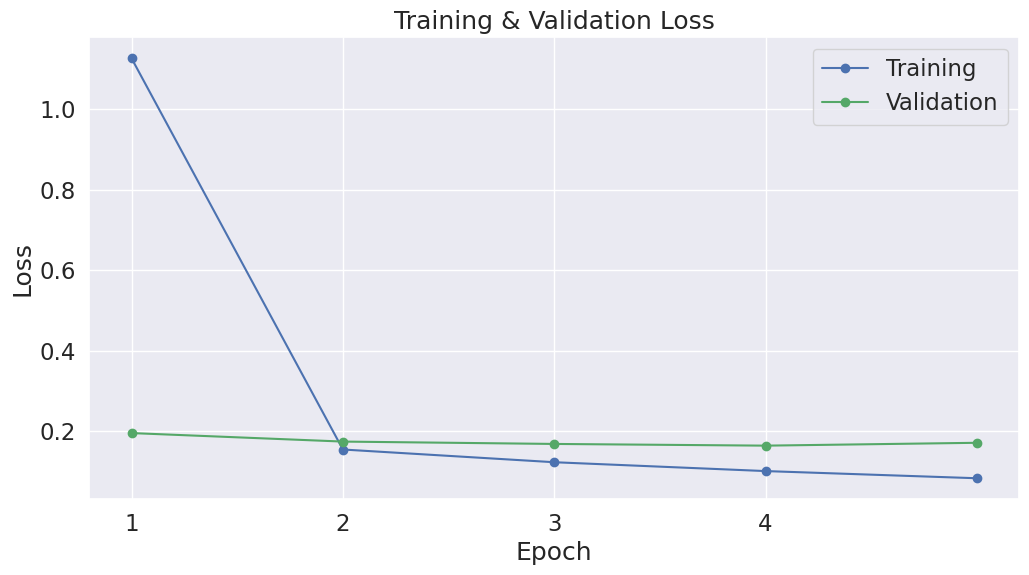

In [18]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [19]:
formal_sentence = "I'm really hungry. Do you want to eat lunch with me?"
prompt = f"<|startoftext|> <Formal:> {formal_sentence} <Translate> <Slang:>"

In [20]:
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

In [21]:
sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                max_length = 50,
                                top_k=75,
                                temperature=1.3,
                                top_p=0.85,
                                num_return_sequences=5,
                                pad_token_id=tokenizer.pad_token_id
                                )
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0:   I'm really hungry. Do you want to eat lunch with me?   I'm super hungry, yolo? You tryna slide and grab some grub? 😎  I'm mad hungry, you try


1:   I'm really hungry. Do you want to eat lunch with me?   I'm mad hungry, can't wait to turn up? 🔥  I'm mad hungry, can't wait to turn up!


2:   I'm really hungry. Do you want to eat lunch with me?   I'm mad hungry, you tryna slide me? 😴🔥  I'm mad hungry, you tryna slide me?


3:   I'm really hungry. Do you want to eat lunch with me?   Yo, you down to hit up my lunch sesh? 😎  I'm so hungry, you tryna slide me? 


4:   I'm really hungry. Do you want to eat lunch with me?   I'm super hungry, yolo? Wanna slide to the cafeteria to grab some grub? ✌️  Yo, I'm




In [22]:
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [23]:
!ls -l --block-size=K ./model_save/

total 487568K
-rw-r--r-- 1 root root      1K Dec  9 22:21 added_tokens.json
-rw-r--r-- 1 root root      1K Dec  9 22:21 config.json
-rw-r--r-- 1 root root      1K Dec  9 22:21 generation_config.json
-rw-r--r-- 1 root root    446K Dec  9 22:21 merges.txt
-rw-r--r-- 1 root root 486123K Dec  9 22:21 model.safetensors
-rw-r--r-- 1 root root      2K Dec  9 22:21 special_tokens_map.json
-rw-r--r-- 1 root root      2K Dec  9 22:21 tokenizer_config.json
-rw-r--r-- 1 root root    976K Dec  9 22:21 vocab.json


In [24]:
!ls -l --block-size=M ./model_save/model.safetensors

-rw-r--r-- 1 root root 475M Dec  9 22:21 ./model_save/model.safetensors


In [27]:
# Example of slang to formal translation
slang_sentence = "I'm drained fr"
prompt_slang_to_formal = f"<|startoftext|> <Slang:> {slang_sentence} <Translate> <Formal:>"

generated_slang_to_formal = torch.tensor(tokenizer.encode(prompt_slang_to_formal)).unsqueeze(0)
generated_slang_to_formal = generated_slang_to_formal.to(device)

sample_outputs_slang_to_formal = model.generate(
                                generated_slang_to_formal,
                                do_sample=True,
                                max_length = 30, # Increased max_length to allow for longer formal translations
                                top_k=50,   # sample from the top-k most probable tokens
                                temperature=1.2,  # a parameter to control randomness on the final softmax function!
                                top_p=0.95, # nucleus sampling, sample from the subset of most probable tokens with a cumulative probability of p
                                num_return_sequences=5,
                                pad_token_id=tokenizer.pad_token_id # pass the padding token ID explicitly, otherwise you'd get a warning.
                                )

print("\n--- Slang to Formal Translations ---\n")
for i, sample_output in enumerate(sample_outputs_slang_to_formal):
print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))



--- Slang to Formal Translations ---

0:   I'm drained fr   Hey, I just got back from hanging out with my friends at the park.  


1:   I'm drained fr   Hey, I gotta finish my homework and I'm ready to chill.   Yo


2:   I'm drained fr   I'm just vibing and chilling with my friends today.   I'm so


3:   I'm drained fr   I'm really tired today, so I think I just want to chill at home. 


4:   I'm drained fr   I think I'm so drained after a long day at school.   I'm


